<a href="https://www.bigdatauniversity.com"><img src="https://ibm.box.com/shared/static/cw2c7r3o20w9zn8gkecaeyjhgw3xdgbj.png" width="400" align="center"></a>

<h1 align="center"><font size="5">Clasificación con Python</font></h1>


En este cuaderno trataremos de practicar todos los algoritmos de clasificación aprendidos durante el curso.

Cargaremos un conjunto de datos mediante la librería Pandas, aplicaremos los siguientes algoritmos y encontraremos el mejor para este conjunto en específico con métodos precisos de evaluación.

Cargemos primero las librerías necesarias:


In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### Acerca del conjunto de datos


Este conjunto de datos es sobre prestamos pasados. El conjunto **Loan_train.csv** incluye detalles sobre 346 clientes cuyos prestamos estan pagados o pendientes de cobrar.

| Campo          | Descripción                                                                           |
| -------------- | ------------------------------------------------------------------------------------- |
| Loan_status    | El prestamos puede estar pagado o pendiente                                           |
| Principal      | Cantidad del prestamo principal                                                       |
| Terms          | Términos del cobro del prestamo, que pueden ser semanales, quincenales o mensuales    |
| Effective_date | La fecha cuando el prestamo fue creado                                                |
| Due_date       | Debido a que se programa para pagarse una sola vez, solo hay una fecha de vencimiento |
| Age            | Edad del solicitante                                                                  |
| Education      | Escolaridad del solicitante                                                           |
| Gender         | Genero del solicitante                                                                |


Descargemos el conjunto de datos


In [3]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2021-11-10 16:57:29--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.001s  

2021-11-10 16:57:29 (17.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Cargar datos desde el archivo CSV


In [4]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [5]:
df.shape

(346, 10)

### Convertir a un objeto de tipo fecha(date)/tiempo(time)


In [6]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Visualización de los Datos y pre procesamiento


Veamos cuantas de cada clase existen en el conjunto de datos. 


In [7]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 personas han saldado el préstamo a tiempo, mientras 86 han sido llamados a pagar


Grafiquemos algunas columnas para entender mejor los datos:


In [8]:
# observación: la instalación de seaborn puede tomar algunos minutos
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



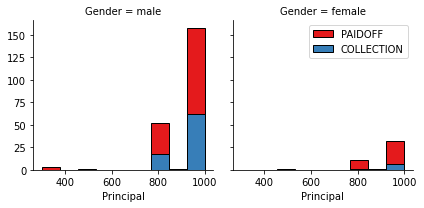

In [9]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

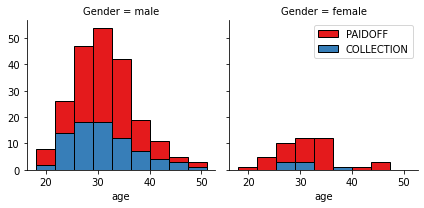

In [10]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre procesamiento: selección/extracción de características


### Veamos el día de la semana en que la gente obtuvo el préstamo


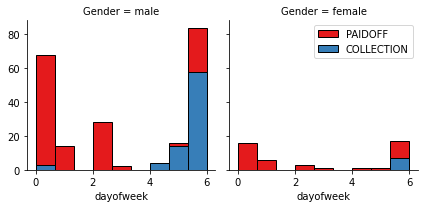

In [11]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


Observamos que la gente que obtuvo el préstamo al final de la semana no lo pagó. Utilicemos la binarización para establecer unops valores límite menores de 4


In [12]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convertir características categóricas en valores numéricos


Observemos la característica de genero:


In [13]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86% de las mujeres pagan sus prestamos mientras que el 73% de los hombres lo hacen.


Convirtamos en 0 a los hombres y a las mujeres en 1:


In [14]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## Codificación One Hot

#### ¿Qué hay acerca de la educación?


In [15]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Característica antes de la codificación One Hot


In [16]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Utilice la técnica de codificación One Hot para transformar las variables categóricas en binarias y agrégelas al dataframe de características


In [17]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Selección de característica


Definamos los conjuntos de características, X:


In [18]:
X = Feature.values
X[0:5]

array([[1000,   30,   45,    0,    0,    0,    1,    0],
       [1000,   30,   33,    1,    0,    1,    0,    0],
       [1000,   15,   27,    0,    0,    0,    0,    1],
       [1000,   30,   28,    1,    1,    0,    0,    1],
       [1000,   30,   29,    0,    1,    0,    0,    1]])

¿Cuales son nuestras etiquetas?


In [19]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Datos Normalizados


La estandarización de los datos le da a estos una media de cero y varianza con valor de la unidad (tecnicamente debería hacerse despues de la división entre grupos de prueba y entrenamiento)


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Clasificación


Ahora es su turno, utilice el conjunto de entrenamiento para construir un modelo preciso. Despues use el conjunto de validación para reportar la precisión del modelo. 
Deberá utilizar el siguiente algoritmo:

-   K Nearest Neighbor(KNN)
-   Arbol de Decisión
-   Maquina de Soporte Vectorial (SVM) 
-   Regresión Logística

**Observaciónes:** 

-   Puede ir arriba y cambiar el pre procesamiento, la selección y extracción de características, etc, para mejorar el modelo.
-   Deberá utilizar alguna de las librerías para el desarrollo de algoritmos de clasificación; ya sea scikit-learn, Scipy o Numpy
-   Deberá incluir el código del algoritmo en las siguientes celdas.


# K Nearest Neighbor(KNN)

Observación: Deberá encontrar el mejor valor de k para construir el modelo con la mejor eficacia.
**Advertencia:** No deberá utilizar **loan_test.csv** para encontrar el mejor valor de k, sin embargo, puede dividir train_loan.csv para entrenamiento y pruebas para encontrar el mejor valor de **k**.


In [21]:
# Definimos los grupos de entrenamiento y prueba.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=4)
print('Set de Entrenamiento:',X_train.shape, y_train.shape)
print('Set de prueba:', X_test.shape, y_test.shape)


Set de Entrenamiento: (276, 8) (276,)
Set de prueba: (70, 8) (70,)


In [23]:
# Definimos el modelo de los K-vecinos, inicialmente con k = 3
from sklearn.neighbors import KNeighborsClassifier
k = 7
#Entrenar el Modelo y Predecir
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
neigh
from sklearn import metrics
print("Entrenar el set de Certeza: ",metrics.accuracy_score(y_train,neigh.predict(X_train)))
print("Probar el set de Certeza: ",metrics.accuracy_score(y_test,neigh.predict(X_test)))

Entrenar el set de Certeza:  0.8079710144927537
Probar el set de Certeza:  0.7857142857142857


In [24]:
# Definimos in iterador para probar distintos k en un rango de 1 a 15, de forma de encontrar el k màs eficiente.
Ks=15
mean_acc=np.zeros((Ks-1))
ConfustionMx=[];
for n in range (1,Ks):
#Entrenar el Modelo y Predecir
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1]=metrics.accuracy_score(y_test,neigh.predict(X_test))
mean_acc
for k, s in zip(range(1,Ks),mean_acc):
    print('Para KNN:',k,', la precisión del modelo es :',s)

Para KNN: 1 , la precisión del modelo es : 0.6714285714285714
Para KNN: 2 , la precisión del modelo es : 0.6571428571428571
Para KNN: 3 , la precisión del modelo es : 0.7142857142857143
Para KNN: 4 , la precisión del modelo es : 0.6857142857142857
Para KNN: 5 , la precisión del modelo es : 0.7571428571428571
Para KNN: 6 , la precisión del modelo es : 0.7142857142857143
Para KNN: 7 , la precisión del modelo es : 0.7857142857142857
Para KNN: 8 , la precisión del modelo es : 0.7571428571428571
Para KNN: 9 , la precisión del modelo es : 0.7571428571428571
Para KNN: 10 , la precisión del modelo es : 0.6714285714285714
Para KNN: 11 , la precisión del modelo es : 0.7
Para KNN: 12 , la precisión del modelo es : 0.7285714285714285
Para KNN: 13 , la precisión del modelo es : 0.7
Para KNN: 14 , la precisión del modelo es : 0.7


In [25]:
print("La mejor aproximación de certeza fue con ",mean_acc.max(),"con k=",mean_acc.argmax()+1)

La mejor aproximación de certeza fue con  0.7857142857142857 con k= 7


# Arbol de Decisión


In [26]:
#Definimos el modelo, y las predicciones para las pruebas. 
from sklearn.tree import DecisionTreeClassifier
paidTree = DecisionTreeClassifier(criterion="entropy", max_depth = 6)
paidTree.fit(X_train, y_train)
predpaidTree = paidTree.predict(X_test)
for p, r in zip(predpaidTree[0:10],y_test[0:10]):
    print('Para la predicción',p,', el valor del test es :',r)

Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción COLLECTION , el valor del test es : COLLECTION
Para la predicción COLLECTION , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF
Para la predicción PAIDOFF , el valor del test es : PAIDOFF


In [27]:
print("Precisión de los Arboles de Decisión: ",metrics.accuracy_score(y_test,predpaidTree), ", para max_depth = 6 ")

Precisión de los Arboles de Decisión:  0.7714285714285715 , para max_depth = 6 


In [28]:
# Definimos in iterador para probar distintos separadores en un rango de 1 a 15, de forma de encontrar el más eficiente.
KTs=15
meanTree_acc=np.zeros((KTs-1))
ConfustionMtx=[];
for n in range (1,KTs):
#Entrenar el Modelo y Predecir
    paidTree2 = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    paidTree2.fit(X_train, y_train)
    predpaidTree2 = paidTree2.predict(X_test)
    meanTree_acc[n-1]=metrics.accuracy_score(y_test,predpaidTree2)
meanTree_acc
for m, s in zip(range(1,KTs),meanTree_acc):
    print('Para max_depth:',m,', la precision del modelo es:',s)
    
print("La mejor Precision del Arbol de decisiones fue con ",meanTree_acc.max(),"con max_depth=",meanTree_acc.argmax()+1)

Para max_depth: 1 , la precision del modelo es: 0.7857142857142857
Para max_depth: 2 , la precision del modelo es: 0.7857142857142857
Para max_depth: 3 , la precision del modelo es: 0.6142857142857143
Para max_depth: 4 , la precision del modelo es: 0.6142857142857143
Para max_depth: 5 , la precision del modelo es: 0.6428571428571429
Para max_depth: 6 , la precision del modelo es: 0.7714285714285715
Para max_depth: 7 , la precision del modelo es: 0.7571428571428571
Para max_depth: 8 , la precision del modelo es: 0.7571428571428571
Para max_depth: 9 , la precision del modelo es: 0.6571428571428571
Para max_depth: 10 , la precision del modelo es: 0.7
Para max_depth: 11 , la precision del modelo es: 0.6857142857142857
Para max_depth: 12 , la precision del modelo es: 0.7142857142857143
Para max_depth: 13 , la precision del modelo es: 0.7142857142857143
Para max_depth: 14 , la precision del modelo es: 0.7285714285714285
La mejor Precision del Arbol de decisiones fue con  0.7857142857142857 c

# Maquina de Soporte Vectorial (SVM)


In [29]:
# Definimos el modelo.
from sklearn import svm
clf=svm.SVC(kernel='rbf')
clf.fit(X_train,y_train)
yhat2 = clf.predict(X_test)
yhat2

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'COLLECTION', 'PAIDOFF', 'COLLECTION',
       'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [30]:
# Usamos la definición de la matriz de confusión vista en los laboratorios.
from sklearn.metrics import classification_report
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Calculamos los indicadores de precisión y f1-score
print (classification_report(y_test, yhat2))

              precision    recall  f1-score   support

  COLLECTION       0.36      0.27      0.31        15
     PAIDOFF       0.81      0.87      0.84        55

    accuracy                           0.74        70
   macro avg       0.59      0.57      0.57        70
weighted avg       0.72      0.74      0.73        70



Confusion matrix, without normalization
[[ 4 11]
 [ 7 48]]


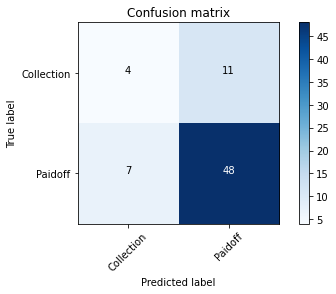

In [31]:
# Calculamos y graficamos la matriz de  confusión:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, yhat2)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Collection','Paidoff'],normalize= False,  title='Confusion matrix')

In [32]:
# Probamos con otro kernelling a ver si cambia el resultado:
clf2=svm.SVC(kernel='linear')
clf2.fit(X_train,y_train)
yhat3 = clf2.predict(X_test)
print (classification_report(y_test, yhat3))
print ("Precisión del modelo SVM con 'rbf' es de: ",metrics.accuracy_score(y_test,yhat2))
print ("Precisión del modelo SVM con 'linear' es de: ",metrics.accuracy_score(y_test,yhat3))

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

    accuracy                           0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Precisión del modelo SVM con 'rbf' es de:  0.7428571428571429
Precisión del modelo SVM con 'linear' es de:  0.7857142857142857


/opt/conda/envs/Python-3.8-main/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Regresión Logística


In [33]:
# Definimos el modelo LR
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat3 = LR.predict(X_test)
yhat3[0:10]

array(['COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF',
       'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

In [34]:
#Usamos predict_proba para predecir  estimaciones para todas las clases P(Y=1|X ) y P(Y=0|X)
yhat_prob = LR.predict_proba(X_test)
yhat_prob[0:10]
# Calculamos Log loss( pérdida logarítmica) para medir el rendimiento de un clasificador.
from sklearn.metrics import log_loss
print ("LogLoss con solver 'liblinear' :%.4f" %log_loss(y_test, yhat_prob))

LogLoss con solver 'liblinear' :0.5772


In [35]:
# Probamos el LR de nuevo , utilizando valores diferentes de solucionador y regularización
LR2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat_prob2 = LR2.predict_proba(X_test)
print ("LogLoss con solver 'sag' :%.4f" %log_loss(y_test, yhat_prob2))

LogLoss con solver 'sag' :0.4920


# Evaluación del Modelo con el Conjunto de Prueba


In [36]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

Primero descarge y carge el conjunto de pruebas:


In [37]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-11-10 17:00:16--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-11-10 17:00:16 (63.8 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Cargar el conjunto de prueba para la evaluación


In [38]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [39]:
# Realizamos las transformaciones necesarias:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
print(test_df['loan_status'].value_counts())
print(test_df.groupby(['Gender'])['loan_status'].value_counts(normalize=True))
print('Gender = 0, male , and Gender = 1, female')
print(test_df.groupby(['education'])['loan_status'].value_counts(normalize=True))
test_df[['Principal','terms','age','Gender','education']].head()
Feature2 = test_df[['Principal','terms','age','Gender','weekend']]
Feature2 = pd.concat([Feature2,pd.get_dummies(test_df['education'])], axis=1)
# Eliminamos niveles educativos que no presentan diferencias entre pagar y no pagar, y ubicamos las variables restantes de 
#educacion como columnas
Feature2.drop(['Master or Above'], axis = 1,inplace=True)
Feature2.head()

PAIDOFF       40
COLLECTION    14
Name: loan_status, dtype: int64
Gender  loan_status
0       PAIDOFF        0.744186
        COLLECTION     0.255814
1       PAIDOFF        0.727273
        COLLECTION     0.272727
Name: loan_status, dtype: float64
Gender = 0, male , and Gender = 1, female
education             loan_status
Bechalor              PAIDOFF        1.000000
High School or Below  PAIDOFF        0.523810
                      COLLECTION     0.476190
Master or Above       PAIDOFF        1.000000
college               PAIDOFF        0.826087
                      COLLECTION     0.173913
Name: loan_status, dtype: float64


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [40]:
# Definimos las variables independientes X2 y dependiente y2
X2 = Feature2.values
print("X2:",X2[0:5])
y2 = test_df['loan_status'].values
print("y2: ",y2[0:5])
X2std = preprocessing.StandardScaler().fit(X2).transform(X2)
print("X2 std:" ,X2std[0:5])

X2: [[1000   30   50    1    0    1    0    0]
 [ 300    7   35    0    1    0    0    0]
 [1000   30   43    1    1    0    1    0]
 [1000   30   26    0    1    0    0    1]
 [ 800   15   29    0    1    1    0    0]]
y2:  ['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
X2 std: [[ 0.49  0.93  3.06  1.98 -1.3   2.4  -0.8  -0.86]
 [-3.56 -1.7   0.53 -0.51  0.77 -0.42 -0.8  -0.86]
 [ 0.49  0.93  1.88  1.98  0.77 -0.42  1.25 -0.86]
 [ 0.49  0.93 -0.98 -0.51  0.77 -0.42 -0.8   1.16]
 [-0.67 -0.79 -0.48 -0.51  0.77  2.4  -0.8  -0.86]]


In [41]:
# Calculamos los indicadores usando la muestra entera en base al set de entrenamiento de la muestra.

# K-vecinos

K_predict3 = neigh.predict(X2std)
print("Precision del modelo KNN : %.4f"%metrics.accuracy_score(y2,K_predict3))
print("F1_score del modelo KNN : %.4f"%f1_score(y2,K_predict3, average='weighted'))
print("Jaccard score del modelo  KNN : %.4f"%jaccard_score(y2,K_predict3, pos_label= "PAIDOFF"))

#Arbol de decision

predpaidTree3 = paidTree.predict(X2std)
print("Precision del modelo Árbol de decisión: %.4f"%metrics.accuracy_score(y2,predpaidTree3))
print("F1_score del modelo Árbol de decisión: %.4f"% f1_score(y2,predpaidTree3,average='weighted'))
print("Jaccard score del modelo Árbol de decisión: %.4f"% jaccard_score(y2,predpaidTree3, pos_label= "PAIDOFF"))

# SVM

clf_predict3= clf.predict(X2std)
print("Precision del modelo SVM: %.4f"%metrics.accuracy_score(y2,clf_predict3))
print("F1_score del modelo SVM: %.4f"%f1_score(y2,clf_predict3,average='weighted'))
print("Jaccard score del modelo SVM: %.4f"% jaccard_score(y2,clf_predict3, pos_label= "PAIDOFF"))

# Regresion Logística LR

LR_predict3 = LR.predict(X2std)
LR_proba3= LR.predict_proba(X2std)
print("Precision del modelo LR : %.4f"%metrics.accuracy_score(y2,LR_predict3))
print("F1_score del modelo LR : %.4f"% f1_score(y2,LR_predict3,average='weighted'))
print("Jaccard score del modelo LR: %.4f"% jaccard_score(y2,LR_predict3, pos_label= "PAIDOFF"))
print("Log loss del modelo LR: %.4f"% log_loss(y2, LR_proba3))



Precision del modelo KNN : 0.6852
F1_score del modelo KNN : 0.6602
Jaccard score del modelo  KNN : 0.6667
Precision del modelo Árbol de decisión: 0.7222
F1_score del modelo Árbol de decisión: 0.6705
Jaccard score del modelo Árbol de decisión: 0.7115
Precision del modelo SVM: 0.7963
F1_score del modelo SVM: 0.7584
Jaccard score del modelo SVM: 0.7800
Precision del modelo LR : 0.7407
F1_score del modelo LR : 0.6604
Jaccard score del modelo LR: 0.7358
Log loss del modelo LR: 0.5672


In [42]:
# Definimos el Reporte en base a los indicadores usando la muestra entera ( y2 y X2std )
Reporte_dict3 = {'Algoritmo':['KNN','Árbol de decisión','SVM','Regresion Logística'],
          'Jaccard':["%.4f"%jaccard_score(y2,K_predict3, pos_label= "PAIDOFF"),"%.4f"%jaccard_score(y2,predpaidTree3, pos_label= "PAIDOFF"),\
                    "%.4f"%jaccard_score(y2,clf_predict3, pos_label= "PAIDOFF"),"%.4f"%jaccard_score(y2,LR_predict3, pos_label= "PAIDOFF")],
          'F1_score':["%.4f"%f1_score(y2,K_predict3, average='weighted'),"%.4f"%f1_score(y2,predpaidTree3,average='weighted'),\
                      "%.4f"%f1_score(y2,clf_predict3,average='weighted'),"%.4f"%f1_score(y2,LR_predict3,average='weighted')],
           'Log_loss':['NA','NA','NA',"%.4f"%log_loss(y2, LR_proba3)]
          }
Reporte3 = pd.DataFrame(Reporte_dict3)
Reporte3.set_index('Algoritmo', inplace=True)
Reporte3

,Jaccard,F1_score,Log_loss
Algoritmo,,,
KNN,0.6667,0.6602,NA
Árbol de decisión,0.7115,0.6705,NA
SVM,0.7800,0.7584,NA
Regresion Logística,0.7358,0.6604,0.5672


# Reporte

Deberá reportar la precisión del modelo utilizando distintas métricas de evaluación:


| Algoritmo           | Jaccard | F1 | LogLoss |
| ------------------- | ------- | -- | ------- |
| KNN                 | ?       | ?  | NA      |
| Arbol de Decisión   | ?       | ?  | NA      |
| SVM                 | ?       | ?  | NA      |
| Regresión Logística | ?       | ?  | ?       |


<h2>¿Quiere aprender mas?</h2>

IBM SPSS Modeler es una plataforma para el análisis que contiene muchos algoritmos de aprendizaje automático (machine learning). Ha sido diseñado con el fin de ofrecer predicciones inteligentes a las decisiones hechas por personas, grupos, sistemas - con la compañia como un todo. Una prueba gratuita esta disponible a traves de este curso desde aqui: <a href="http://cocl.us/ML0101EN-SPSSModeler">SPSS Modeler</a>

Además, puede utilizar Watson Studio para ejecutar estos cuardernos mas rápido y con conjuntos de datos mas grandes. Watson Studio es la solución líder de IBM en la nube para científicos de datos, contruido por científicos de datos. Con los cuadernos de Jupyter, RStudio, Apache Spark y librerías pre instaladas en la nube, Watson Studio permite a los científicos de datos colaborar en sus proyectos sin necesidad de instalar nada. Unase a la gran comunidad de usuarios de Watson Studio hoy con un cuenta gratuita en <a href="https://cocl.us/ML0101EN_DSX">Watson Studio</a>

<h3>Gracias por terminar esta lección</h3>

<h4>Autor:  <a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a></h4>
<p><a href="https://ca.linkedin.com/in/saeedaghabozorgi">Saeed Aghabozorgi</a>, PhD es un Científico de Datos para IBM con una trayectoria de desarrollo de aplicaciones a nivel empresarial que han ayudado a mejorar la habilidad de transformar información en conocimiento practico. Es un investigador en el campo de la minería de datos y experto en el desarrollo de métodos analíticos avanzados como son el aprendizaje automático y el modelado estadístico de grandes conjuntos de datos.</p>

<hr>

<p>Copyright &copy; 2018 <a href="https://cocl.us/DX0108EN_CC">Cognitive Class</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.</p>


In [47]:
import datetime
print("Fecha de terminado:",datetime.datetime.today().strftime('%Y/%m/%d %HH-%MM'))

Fecha de terminado: 2021/11/09 14H-10M
